## Test stream beds

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter, generic_filter as gf
from dask import array as da
from numba import jit

### compination of stream_amp and hpmf

Test result, Zone 12: Alignment Score (Mean Minimum Norm): 0.08862505507023982

In [ ]:
# Function to create a circular mask
def create_circular_mask(radius):
    size = 2 * radius + 1
    y, x = np.ogrid[-radius:radius + 1, -radius:radius + 1]
    mask = x**2 + y**2 <= radius**2
    return mask

@jit(nopython=True)
def amplify_and_filter(stream_amp, hpmf_reclassified, mask_radius=3):
    """
    Amplifies stream features and applies a mask to highlight streambed areas.

    Parameters:
        stream_amp (np.ndarray): Stream amplification data.
        hpmf_reclassified (np.ndarray): Reclassified HPMF data.
        mask_radius (int): Base radius for the circular mask.

    Returns:
        np.ndarray: Filtered streambed feature map.
    """
    output = np.zeros_like(stream_amp, dtype=np.float32)

    for i in range(stream_amp.shape[0]):
        for j in range(stream_amp.shape[1]):
            if stream_amp[i, j] > 0:  # If stream is amplified
                # Dynamically adjust the mask size based on HPMF classification
                dynamic_radius = mask_radius + hpmf_reclassified[i, j] // 50
                dynamic_radius = max(1, min(dynamic_radius, 15))  # Clamp radius to reasonable bounds
                mask = create_circular_mask(dynamic_radius)
                mask_size = mask.shape[0] // 2
                
                # Apply the mask
                for mi in range(-mask_size, mask_size + 1):
                    for mj in range(-mask_size, mask_size + 1):
                        if 0 <= i + mi < stream_amp.shape[0] and 0 <= j + mj < stream_amp.shape[1]:
                            if mask[mi + mask_size, mj + mask_size]:
                                output[i + mi, j + mj] += stream_amp[i, j] * hpmf_reclassified[i, j]
    return output

def process_streambeds(zone_number, features_path, output_dir, mask_radius=3):
    """
    Process streambeds by combining stream amplification and HPMF classifications.

    Parameters:
        zone_number (int): Zone number to process.
        features_path (str): Path to feature files.
        output_dir (str): Directory for saving output.
        mask_radius (int): Base radius for the circular mask.
    """
    # Load input data
    stream_amp = np.load(f"{features_path}/stream_amp_{zone_number}.npy")
    hpmf_raw = np.load(f"{features_path}/HPMF_{zone_number}.npy")

    # Reclassify HPMF data
    hpmf_reclassified = _reclassify_hpmf_filter(hpmf_raw)

    # Amplify streams and apply mask-based filtering
    streambed_features = amplify_and_filter(stream_amp, hpmf_reclassified, mask_radius)

    # Apply Gaussian smoothing for visualization
    smoothed_streambeds = gaussian_filter(streambed_features, sigma=2)

    # Visualize the result
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(stream_amp, cmap="viridis", origin="lower")
    plt.title(f"Stream Amplification - Zone {zone_number}")
    plt.colorbar(label="Stream Amplification")

    plt.subplot(1, 2, 2)
    plt.imshow(smoothed_streambeds, cmap="plasma", origin="lower")
    plt.title(f"Streambed Features - Zone {zone_number}")
    plt.colorbar(label="Streambed Intensity")

    plt.tight_layout()
    plt.show()

    # Save the processed output
    np.save(f"{output_dir}/streambed_features_zone{zone_number}.npy", streambed_features)
    print(f"Processed streambed features saved to {output_dir}.")

# Example Usage
zone_number = 12
features_path = "../../01_Data/01_Raw/features/features"
output_dir = "./../01_Data/01_Raw/features/tests"
process_streambeds(zone_number, features_path, output_dir)


### Detecting meandering rivers in images

https://dsp.stackexchange.com/questions/2533/detecting-meandering-rivers-in-images 

In [1]:
import numpy as np
import dask.array as da
from dask_image.ndfilters import generic_filter as d_gf
import matplotlib.pyplot as plt
from numba import jit

##### Same code, DASK optimization, with save option
Both saved for comapring and for avoid mistakes.

Test result, Zone 12: Alignment Score (Mean Minimum Norm): 0.08862505507023982

Zone 12: Loaded HPMF data with shape (5000, 5000)


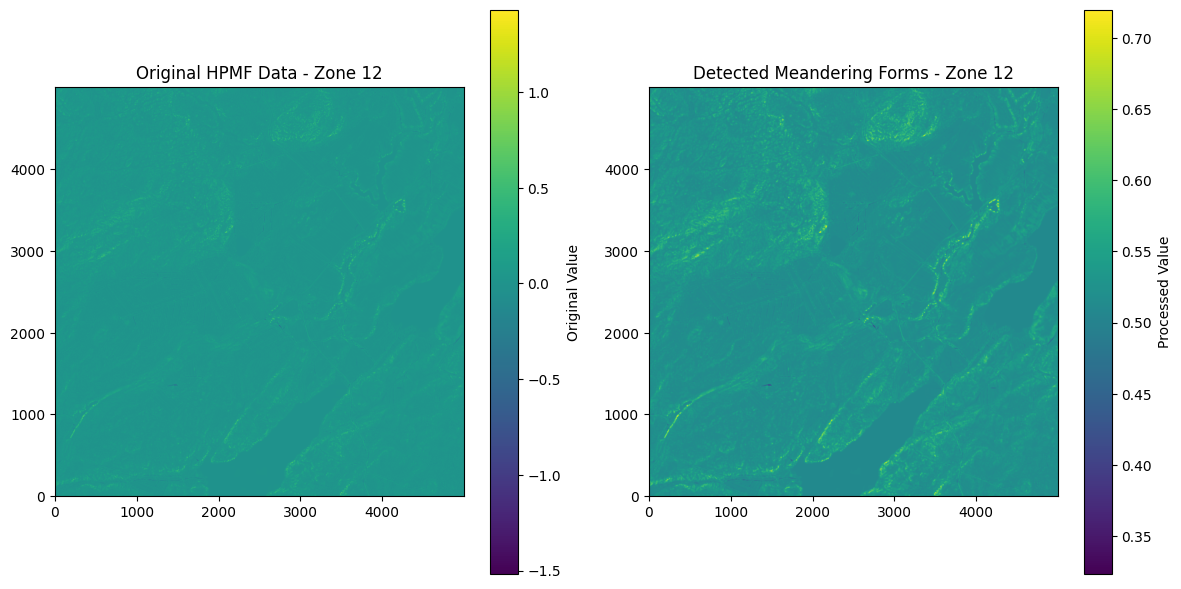

In [3]:

@jit(nopython=True)
def create_circular_mask(radius):
    """
    Creates a fast and efficient circular mask compatible with Dask and large-scale operations.
    """
    size = 2 * radius + 1
    kernel = np.zeros((size, size), dtype=np.uint8)
    for y in range(size):
        for x in range(size):
            if (x - radius) ** 2 + (y - radius) ** 2 <= radius ** 2:
                kernel[y, x] = 1
    return kernel


def compute_mean_min_norm(lines, shift_range=5):
    """
    Compute the mean of the minimum norms between pairs of consecutive lines with shifted alignments.

    Parameters:
    - lines: 2D array where each row represents a "line".
    - shift_range: The maximum shift range to consider when aligning one line to the other.

    Returns:
    - mean_min_norm: The mean of the minimum norms for all line pairs.
    """
    n_lines = len(lines)
    min_norms = []

    for i in range(1, n_lines):
        line1 = lines[i]
        line2 = lines[i - 1]
        norms = []

        for shift in range(-shift_range, shift_range + 1):
            # Shift line2 by `shift` (circular shift)
            shifted_line2 = np.roll(line2, shift)
            # Calculate the norm (Euclidean distance)
            norm = np.linalg.norm(line1 - shifted_line2)
            norms.append(norm)

        # Take the minimum norm for this pair
        min_norms.append(min(norms))

    # Return the mean of all minimum norms
    mean_min_norm = np.mean(min_norms)
    return mean_min_norm


def meandering_detection(data, mask_radius=6):
    """
    Detects meandering forms using circular masks and Dask-compatible filters.

    Parameters:
    - data: Input 2D array (Dask array or NumPy array).
    - mask_radius: Radius of the circular mask.

    Returns:
    - result: Processed 2D array with enhanced meandering forms.
    """
    # Normalize input data for processing
    data_dask = da.from_array(data, chunks=(800, 800))
    data_norm = (data_dask - data_dask.min()) / (data_dask.max() - data_dask.min())

    # Create the circular mask
    circular_mask = create_circular_mask(mask_radius)

    # Apply filters to enhance meandering forms
    enhanced_data = d_gf(
        d_gf(data_norm, np.nanmean, footprint=circular_mask),
        np.nanmedian, footprint=circular_mask
    ).compute(scheduler="processes")

    return enhanced_data


def process_zone_for_meanders(zone_number, features_path, mask_radius=6, shift_range=5):
    """
    Processes HPMF data for a specific zone to detect meandering forms and compute the alignment score.

    Parameters:
    - zone_number: Zone number for the data file.
    - features_path: Path to the features directory containing HPMF files.
    - mask_radius: Radius of the circular mask.
    - shift_range: Shift range for computing alignment.

    Returns:
    - Processed data and alignment score.
    """
    # Load the HPMF data
    hpmf_f = np.load(f"{features_path}/HPMF_{zone_number}.npy")
    print(f"Zone {zone_number}: Loaded HPMF data with shape {hpmf_f.shape}")

    # Process the data to detect meandering forms
    processed_data = meandering_detection(hpmf_f, mask_radius)

    # Compute alignment score (mean minimum norm)
    #alignment_score = compute_mean_min_norm(processed_data, shift_range)

    # Visualize results
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(hpmf_f, cmap="viridis", origin="lower")
    plt.title(f"Original HPMF Data - Zone {zone_number}")
    plt.colorbar(label="Original Value")

    plt.subplot(1, 2, 2)
    plt.imshow(processed_data, cmap="viridis", origin="lower")
    plt.title(f"Detected Meandering Forms - Zone {zone_number}")
    plt.colorbar(label="Processed Value")

    plt.tight_layout()
    plt.show()

    return processed_data #, alignment_score


# Example usage
zone_number = 12
features_path = "../../01_Data/01_Raw/features/features"
mask_radius = 6
shift_range = 15 #7,5m with resolution 0,5m

# Process the specified zone
processed_meanders = process_zone_for_meanders(zone_number, features_path, mask_radius, shift_range)
#processed_meanders, alignment_score = process_zone_for_meanders(zone_number, features_path, mask_radius, shift_range)
#print(f"Zone {zone_number}: Alignment Score (Mean Minimum Norm): {alignment_score}")


### Tallennustesti

Zone 12: Loaded HPMF data with shape (5000, 5000)


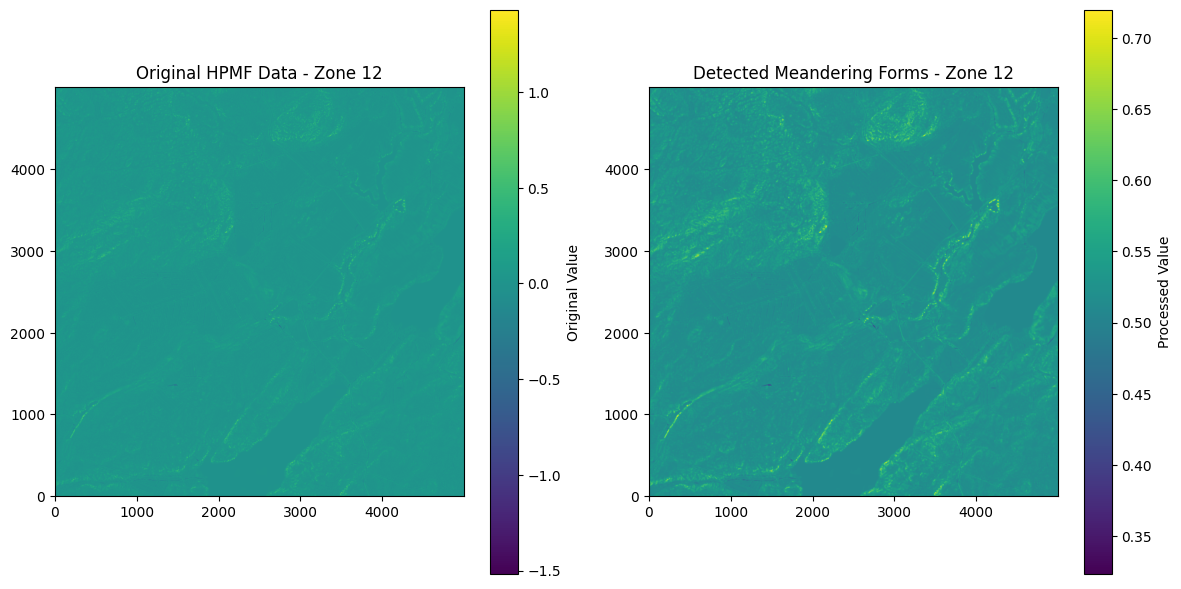

Zone 12: Alignment Score (Mean Minimum Norm): 0.08862505507023982


In [3]:
def process_zone_for_meanders(zone_number, features_path, mask_radius=6, shift_range=5):
    """
    Processes HPMF data for a specific zone to detect meandering forms and compute the alignment score.

    Parameters:
    - zone_number: Zone number for the data file.
    - features_path: Path to the features directory containing HPMF files.
    - mask_radius: Radius of the circular mask.
    - shift_range: Shift range for computing alignment.

    Returns:
    - Processed data and alignment score.
    """
    # Load the HPMF data
    hpmf_f = np.load(f"{features_path}/HPMF_{zone_number}.npy")
    print(f"Zone {zone_number}: Loaded HPMF data with shape {hpmf_f.shape}")

    # Process the data to detect meandering forms
    processed_data = meandering_detection(hpmf_f, mask_radius)

    # Compute alignment score (mean minimum norm)
    alignment_score = compute_mean_min_norm(processed_data, shift_range)

    # Visualize results
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(hpmf_f, cmap="viridis", origin="lower")
    plt.title(f"Original HPMF Data - Zone {zone_number}")
    plt.colorbar(label="Original Value")

    plt.subplot(1, 2, 2)
    plt.imshow(processed_data, cmap="viridis", origin="lower")
    plt.title(f"Detected Meandering Forms - Zone {zone_number}")
    plt.colorbar(label="Processed Value")

    plt.tight_layout()
    plt.show()

    # Save the processed data and alignment score
    np.save(f"../../01_Data/01_Raw/features/processed_meanders_zone_{zone_number}.npy", processed_data)
    
    with open(f"alignment_score_zone_{zone_number}.txt", "w") as file:
        file.write(f"Alignment Score (Mean Minimum Norm) for Zone {zone_number}: {alignment_score}")
    
    return processed_data, alignment_score


# Example usage
zone_number = 12
features_path = "../../01_Data/01_Raw/features/features"
mask_radius = 6
shift_range = 15 #7,5m with resolution 0,5m

# Process the specified zone
processed_meanders, alignment_score = process_zone_for_meanders(zone_number, features_path, mask_radius, shift_range)
print(f"Zone {zone_number}: Alignment Score (Mean Minimum Norm): {alignment_score}")


### Alignment score (mean minimum norm)
save and plot histogram, note: example. Use your own data with multiple features.

Zone 12: Loaded HPMF data with shape (5000, 5000)


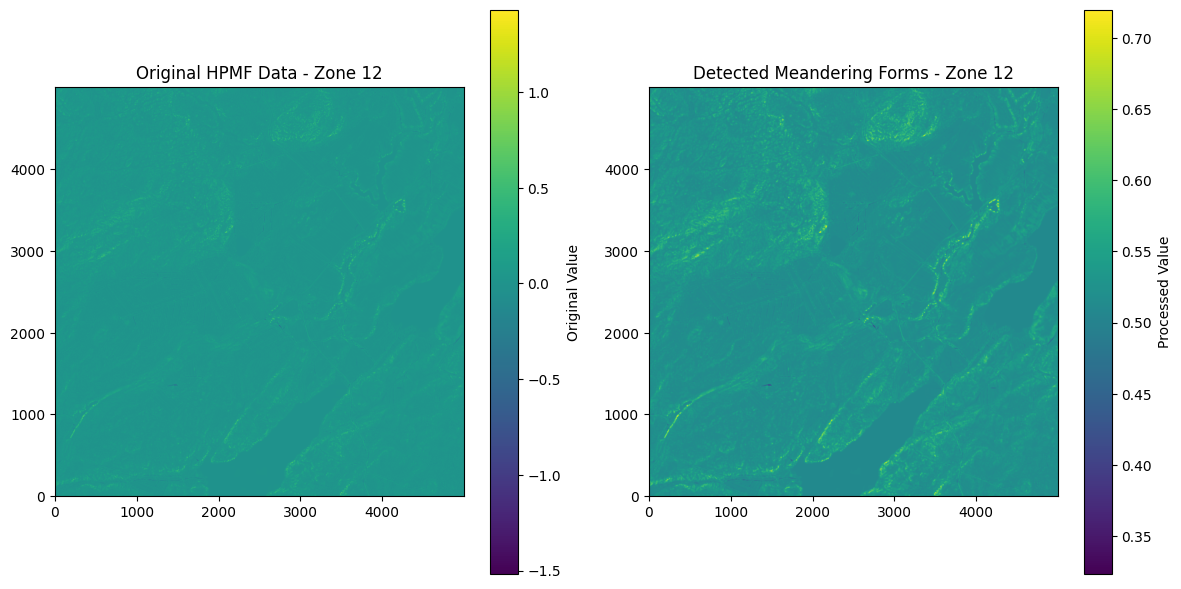

Zone 12: Alignment Score (Mean Minimum Norm): 0.08862505507023982


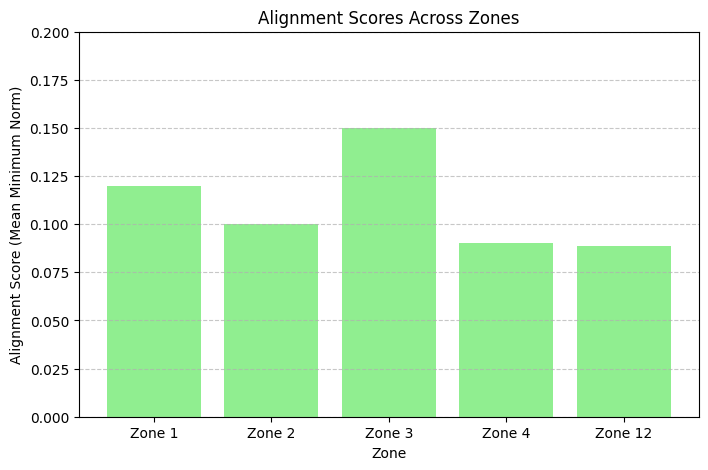

In [2]:
@jit(nopython=True)
def create_circular_mask(radius):
    """
    Creates a fast and efficient circular mask compatible with Dask and large-scale operations.
    """
    size = 2 * radius + 1
    kernel = np.zeros((size, size), dtype=np.uint8)
    for y in range(size):
        for x in range(size):
            if (x - radius) ** 2 + (y - radius) ** 2 <= radius ** 2:
                kernel[y, x] = 1
    return kernel


def compute_mean_min_norm(lines, shift_range=5):
    """
    Compute the mean of the minimum norms between pairs of consecutive lines with shifted alignments.

    Parameters:
    - lines: 2D array where each row represents a "line".
    - shift_range: The maximum shift range to consider when aligning one line to the other.

    Returns:
    - mean_min_norm: The mean of the minimum norms for all line pairs.
    """
    n_lines = len(lines)
    min_norms = []

    for i in range(1, n_lines):
        line1 = lines[i]
        line2 = lines[i - 1]
        norms = []

        for shift in range(-shift_range, shift_range + 1):
            # Shift line2 by `shift` (circular shift)
            shifted_line2 = np.roll(line2, shift)
            # Calculate the norm (Euclidean distance)
            norm = np.linalg.norm(line1 - shifted_line2)
            norms.append(norm)

        # Take the minimum norm for this pair
        min_norms.append(min(norms))

    # Return the mean of all minimum norms
    mean_min_norm = np.mean(min_norms)
    return mean_min_norm


def meandering_detection(data, mask_radius=6):
    """
    Detects meandering forms using circular masks and Dask-compatible filters.

    Parameters:
    - data: Input 2D array (Dask array or NumPy array).
    - mask_radius: Radius of the circular mask.

    Returns:
    - result: Processed 2D array with enhanced meandering forms.
    """
    # Normalize input data for processing
    data_dask = da.from_array(data, chunks=(800, 800))
    data_norm = (data_dask - data_dask.min()) / (data_dask.max() - data_dask.min())

    # Create the circular mask
    circular_mask = create_circular_mask(mask_radius)

    # Apply filters to enhance meandering forms
    enhanced_data = d_gf(
        d_gf(data_norm, np.nanmean, footprint=circular_mask),
        np.nanmedian, footprint=circular_mask
    ).compute(scheduler="processes")

    return enhanced_data


def process_zone_for_meanders(zone_number, features_path, mask_radius=6, shift_range=5):
    """
    Processes HPMF data for a specific zone to detect meandering forms and compute the alignment score.

    Parameters:
    - zone_number: Zone number for the data file.
    - features_path: Path to the features directory containing HPMF files.
    - mask_radius: Radius of the circular mask.
    - shift_range: Shift range for computing alignment.

    Returns:
    - Processed data and alignment score.
    """
    # Load the HPMF data
    hpmf_f = np.load(f"{features_path}/HPMF_{zone_number}.npy")
    print(f"Zone {zone_number}: Loaded HPMF data with shape {hpmf_f.shape}")

    # Process the data to detect meandering forms
    processed_data = meandering_detection(hpmf_f, mask_radius)

    # Compute alignment score (mean minimum norm)
    alignment_score = compute_mean_min_norm(processed_data, shift_range)

    # Visualize results
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(hpmf_f, cmap="viridis", origin="lower")
    plt.title(f"Original HPMF Data - Zone {zone_number}")
    plt.colorbar(label="Original Value")

    plt.subplot(1, 2, 2)
    plt.imshow(processed_data, cmap="viridis", origin="lower")
    plt.title(f"Detected Meandering Forms - Zone {zone_number}")
    plt.colorbar(label="Processed Value")

    plt.tight_layout()
    plt.show()

    # Save the processed data and alignment score
    np.save(f"../../01_Data/01_Raw/features/processed_meanders_zone_{zone_number}.npy", processed_data)
    
    with open(f"alignment_score_zone_{zone_number}.txt", "w") as file:
        file.write(f"Alignment Score (Mean Minimum Norm) for Zone {zone_number}: {alignment_score}")
    
    return processed_data, alignment_score


# Example usage
zone_number = 12
features_path = "../../01_Data/01_Raw/features/features"
mask_radius = 6
shift_range = 15

# Process the specified zone
processed_meanders, alignment_score = process_zone_for_meanders(zone_number, features_path, mask_radius, shift_range)
print(f"Zone {zone_number}: Alignment Score (Mean Minimum Norm): {alignment_score}")

import matplotlib.pyplot as plt

# Example alignment scores for multiple zones - example use your data in the end
zones = [1, 2, 3, 4, 12]
alignment_scores = [0.12, 0.10, 0.15, 0.09, 0.0886]

# Create a bar plot
plt.figure(figsize=(8, 5))
plt.bar([f"Zone {z}" for z in zones], alignment_scores, color="lightgreen")
plt.ylabel("Alignment Score (Mean Minimum Norm)")
plt.xlabel("Zone")
plt.title("Alignment Scores Across Zones")
plt.ylim(0, 0.2)  # Adjust based on your score range
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

